In [1]:
import json
import os
from pycocotools.coco import COCO
import shutil
import numpy as np
from pathlib import Path
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import skimage.io as io
from tqdm import tqdm

In [2]:
def convert_polygon(seg):
    return list(np.array(seg).flatten())
        

In [227]:
common_coco = COCO('/home/user/datasets/pillars_dataset/anns/mps/annotations/instances_Train.json')

loading annotations into memory...
Done (t=1.51s)
creating index...
index created!


In [92]:
len(set([img_ann['file_name'] for img_ann in common_coco['images']]))

26135

In [10]:
path_to_datasets = Path('/home/user/deliseev/tmp/ds/images')
path_to_anns = Path('/home/user/deliseev/tmp/')
path_to_save = Path('/home/user/deliseev/tmp/ds/yolo_images')

In [4]:
train_coco = COCO('/home/user/deliseev/tmp/livecell_coco_train.json')

loading annotations into memory...
Done (t=10.55s)
creating index...
index created!


In [5]:
train_coco.dataset['categories']

[{'supercategory': 'cell', 'id': 1, 'name': 'cell'}]

In [6]:
train_coco.dataset['images'][0]

{'id': 1,
 'width': 704,
 'height': 520,
 'file_name': 'BT474_Phase_A3_2_00d04h00m_3.tif',
 'original_filename': 'BT474_Phase_A3_2_00d04h00m_3.png',
 'url': 'https://darwin.v7labs.com/api/images/870028/original'}

In [16]:
im = Image.open(path_to_datasets / 'livecell_train_val_images/BT474_Phase_A3_2_00d04h00m_3.tif')

In [18]:
w, h = im.size
w, h

(704, 520)

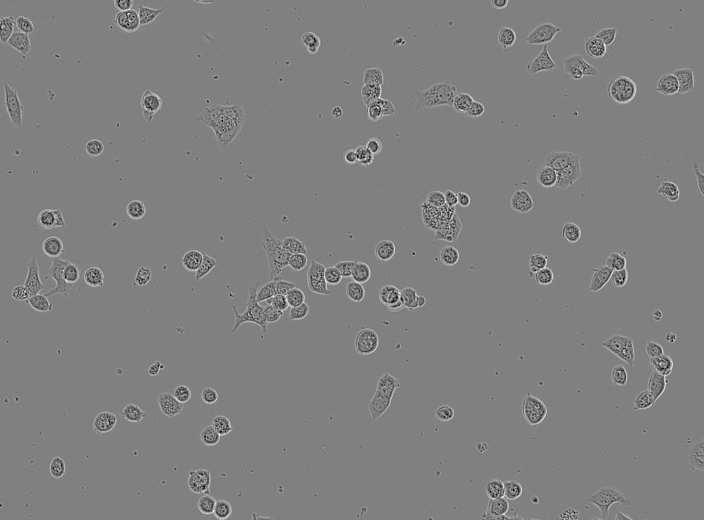

In [21]:
im

In [7]:
len(train_coco.dataset['images'])

3253

In [8]:
# Path('pillars_dataset/13.g-pillar/14254_0_2022-07-20.10-02-54.858919.jpg').name

In [48]:
# def convert_coco_to_yolo(coco_ann):
#     for img_ann in coco_ann.dataset['images']:
#         img_id = img_ann['id']
#         annIds = coco_ann.getAnnIds(imgIds=[img_id], iscrowd=None)
#         anns = coco_ann.loadAnns(annIds)
#         for ann in anns:
#             res = [ann['category_id']]
#             res.extend(convert_polygon(ann['segmentation']))
#             res_str = ' '.join(map(str, res)) + '\n'
        
#         break

In [49]:
# convert_coco_to_yolo(train_coco)

In [24]:
# import cv2
import json

class ConvertCOCOToYOLO:

    def __init__(self, img_folder, json_path, output_path):
        self.img_folder = Path(img_folder)
        self.coco_ann = COCO(json_path)
        self.output_path = Path(output_path)
        
        if not self.output_path.exists():
            os.makedirs(self.output_path)

        if not (self.output_path / 'labels').exists():
            os.makedirs(self.output_path / 'labels')
            
        if not (self.output_path / 'images').exists():
            os.makedirs(self.output_path / 'images')
            

    def convert_polygon(self, seg, w ,h):
        polygon = np.array(seg).reshape(len(seg) // 2, 2)
        polygon = polygon / np.array([w,h])
        return list(polygon.flatten())

    def convert(self):
        # Enter directory to read JSON file
        images = []
        skip_images = 0
        max_x = 0
        max_y = 0
            
        for img_ann in tqdm(self.coco_ann.dataset['images']):
            img_id = img_ann['id']
            annIds = self.coco_ann.getAnnIds(imgIds=[img_id], iscrowd=None)
            if not annIds:
                skip_images += 1
                continue
            anns = self.coco_ann.loadAnns(annIds)
            stem_img = Path(img_ann['file_name']).stem
            label_path = self.output_path / 'labels' / f'{stem_img}.txt'
            image_path = self.output_path / 'images' / f'{stem_img}.png'
            images.append(str(image_path))
            res_str = ''
            img = Image.open(self.img_folder  / img_ann['file_name'])
            w,h = img.size
            
            for ann in anns:
                if not ann['segmentation']:
                    print(ann)
                res = [ann['category_id'] - 1] 
                res.extend(self.convert_polygon(ann['segmentation'][0], w, h))
                res_str += ' '.join(map(str, res)) + '\n'
                
            with open(label_path, 'w') as f:
                f.write(res_str)
            
            img.save(image_path)
        print('skip_images', skip_images)
        with open(self.output_path.parent / f'{self.output_path.name}.txt', 'w') as f:
            f.write('\n'.join(images))


In [25]:
train_converter = ConvertCOCOToYOLO(path_to_datasets / 'livecell_train_val_images', 
                                    path_to_anns / 'livecell_coco_train.json', 
                                    path_to_save / 'train')
train_converter.convert()
test_converter = ConvertCOCOToYOLO(path_to_datasets / 'livecell_test_images', 
                                    path_to_anns / 'livecell_coco_test.json', 
                                    path_to_save / 'test')
test_converter.convert()
val_converter = ConvertCOCOToYOLO(path_to_datasets / 'livecell_train_val_images', 
                                    path_to_anns / 'livecell_coco_val.json', 
                                    path_to_save / 'val')
val_converter.convert()

loading annotations into memory...
Done (t=12.15s)
creating index...
index created!


100%|███████████████████████████████████████| 3253/3253 [02:38<00:00, 20.53it/s]


skip_images 0
loading annotations into memory...
Done (t=6.39s)
creating index...
index created!


100%|███████████████████████████████████████| 1564/1564 [01:15<00:00, 20.68it/s]


skip_images 0
loading annotations into memory...
Done (t=1.26s)
creating index...
index created!


100%|█████████████████████████████████████████| 570/570 [00:27<00:00, 20.44it/s]

skip_images 0


In [30]:
def check_img(stem_name, coco_ann):
    img_id = None
    for img_ann in coco_ann.dataset['images']:
        if stem_name in img_ann['file_name']:
            img_id = img_ann['id']
    file_name = coco_ann.loadImgs(img_id)[0]['file_name']
    I = Image.open(path_to_datasets / 'livecell_train_val_images' / file_name)
    plt.imshow(I)
    plt.axis('off')
    annIds = coco_ann.getAnnIds(imgIds=img_id, iscrowd=None)
    anns = coco_ann.loadAnns(annIds)
    coco_ann.showAnns(anns)

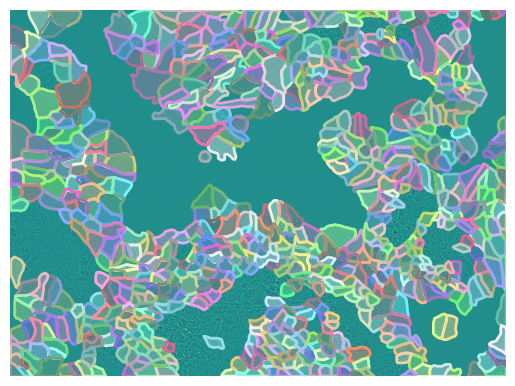

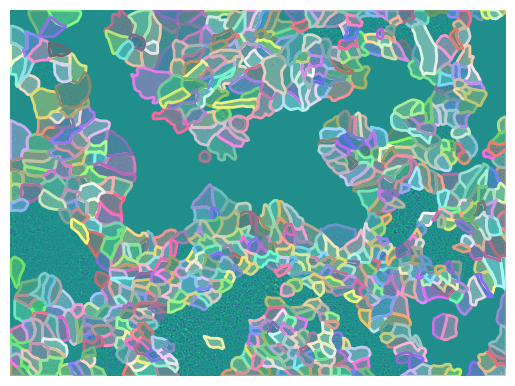

In [31]:
img_id = 1000
check_img(Path(train_coco.dataset['images'][img_id]['file_name']).stem, train_coco)
plt.show()
check_img(Path(train_coco.dataset['images'][img_id]['file_name']).stem, train_coco)
plt.show()